In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import Model
from keras.layers import Input, LSTM, Dropout, Dense, Bidirectional

In [2]:
# STATIC VARIABLES
past_time_gap = 30 
future_time_gap = 30

In [3]:
dfs = []
for i in range(5):
    df = pd.read_csv(f'data/Bitstamp_BTCUSD_20{i+17}_minute.csv')
    dfs.append(df)
    
df = pd.concat(dfs).set_index('unix').sort_index()
df.head()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
unix,,,,,,,,
1483228860,01-01-17 0:01,BTC/USD,966.34,966.34,966.34,966.34,7.610000,7353.847400
1483228920,01-01-17 0:02,BTC/USD,966.16,966.37,966.16,966.37,8.087376,7815.397864
1483228980,01-01-17 0:03,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
1483229040,01-01-17 0:04,BTC/USD,966.37,966.37,966.37,966.37,0.000000,0.000000
1483229100,01-01-17 0:05,BTC/USD,966.43,966.43,966.43,966.43,0.107000,103.408010


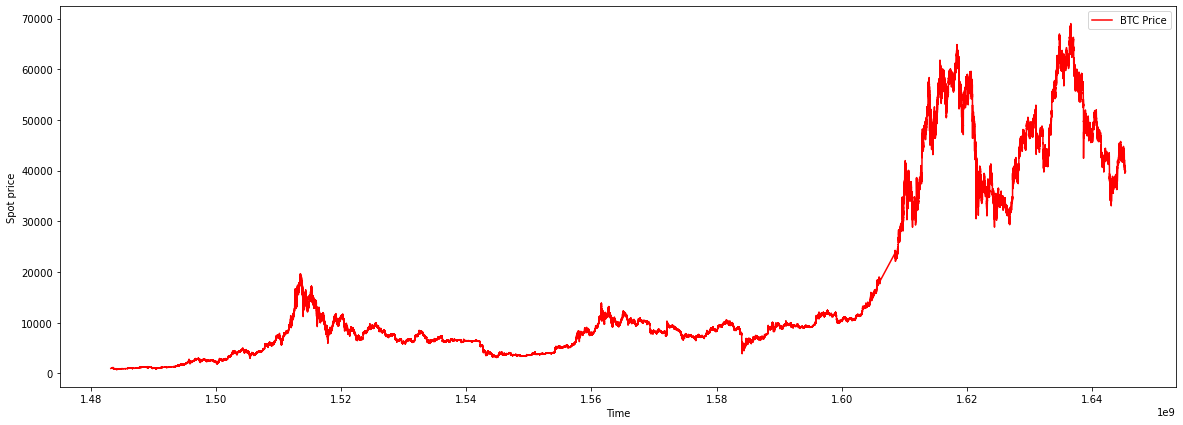

In [4]:
f = plt.figure(figsize=(20, 7))

plt.plot(df.index, df.close, color='red', label='BTC Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Spot price')
plt.show()

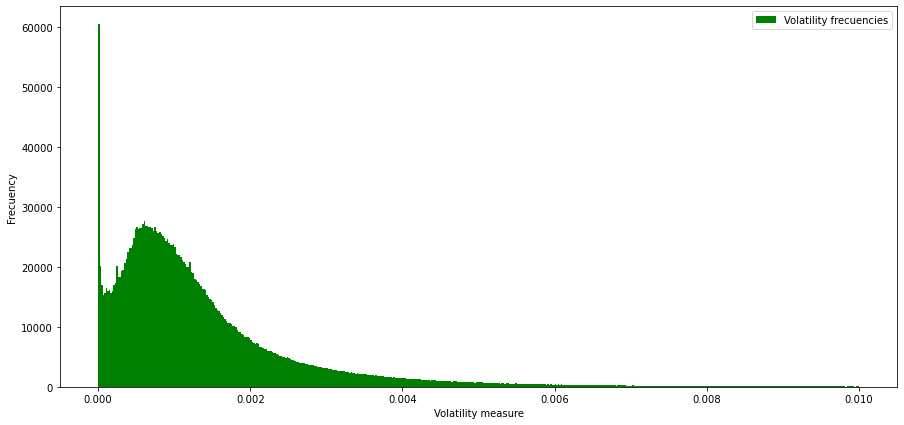

In [5]:
df['volatility'] = (df.high - df.low)/df.close

f = plt.figure(figsize=(15, 7))
plt.hist(df[df.volatility > 0].volatility, bins=500, range=(0, 0.01), color='green', label='Volatility frecuencies')
plt.legend()
plt.xlabel('Volatility measure')
plt.ylabel('Frecuency')
plt.show()

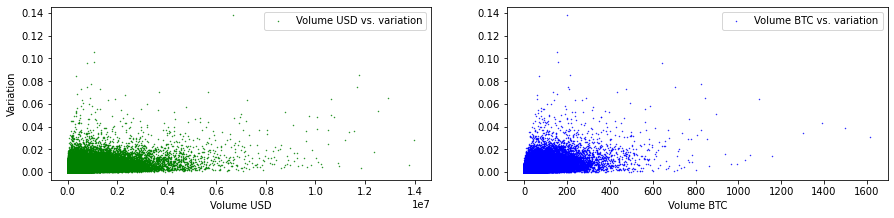

In [6]:
f = plt.figure(figsize=(15, 7))

ax = f.add_subplot(221)
plt.scatter(df['Volume USD'], df.volatility, s=0.2, color='green', label='Volume USD vs. variation')
plt.legend()
plt.xlabel('Volume USD')
plt.ylabel('Variation')

ax = f.add_subplot(222)
plt.scatter(df['Volume BTC'], df.volatility, s=0.2, color='blue', label='Volume BTC vs. variation')
plt.legend()
plt.xlabel('Volume BTC')

plt.show()

In [7]:
# the volume in BTC looks more explanatory on the volatility, so we will drop volume in USD for modelling
df.drop(['Volume USD'], axis=1, inplace=True)

In [8]:
# we will now check if there are any time gaps of missing data. 
(df.index[1:]-df.index[:-1]).value_counts().head()

60         2661381
120              5
2359020          1
Name: unix, dtype: int64

In [9]:
# looks like we have a huge chunk of data missing (almost a month worth of data)
# we will divide the df into two, and then merge both when creating the dataset

df1 = df[df.index < 1608450780]
df2 = df[df.index >= 1608450780]

print('df1 finishes on '+str(df1.date.iloc[-1]))
print('df2 starts on '+str(df2.date.iloc[0]))
print('The time gap is of '+'{:.2f}'.format((df2.index[0] - df1.index[-1])/60/60/24)+' days.')

df1 finishes on 23-11-20 0:36
df2 starts on 20-12-20 7:53
The time gap is of 27.30 days.


In [10]:
(df1.index[1:] - df1.index[:-1]).value_counts().head()

60     2047707
120          4
Name: unix, dtype: int64

In [11]:
(df2.index[1:] - df2.index[:-1]).value_counts().head()

60     613674
120         1
Name: unix, dtype: int64

In [12]:
def fix_timestamp_ranges(df, method='pad'):
    
    initial_length = df.shape[0]
        
    df = df.reindex(range(df.index[0], df.index[-1] + 60, 60), method=method)
    df = df.reset_index()
        
    final_length = df.shape[0]
    print('Adding '+str(final_length-initial_length)+' missing timestamps with '+method+' method.')
    
    return df

In [13]:
df1 = fix_timestamp_ranges(df1, 'pad')
df2 = fix_timestamp_ranges(df2, 'pad')

Adding 4 missing timestamps with pad method.
Adding 1 missing timestamps with pad method.


In [14]:
# We will now create the target variable which we hope will be able to predict.
# It is calculated with this formula: log_return(t) = log(close_price(t+30) / close_price(t))

def add_target_variable(df):
    
    df['future_price'] = df['close'].shift(-15)
    df['log_return'] = (np.log(df.future_price / df.close)).shift(-1)
    df = df[~df.log_return.isnull()]
    
    return df

df1 = add_target_variable(df1)
df2 = add_target_variable(df2)

In [42]:
cols = ['unix', 'close', 'Volume BTC', 'volatility', 'log_return']
features = ['close', 'Volume BTC', 'volatility']
df1 = df1[cols]
df2 = df2[cols]

def create_dataset(df, features, max_lag=1):
    dataset = np.zeros((len(df), max_lag+1, len(features)))
    for i, feature in enumerate(features):
        for j in range(max_lag+1):
            dataset[:, max_lag-j, i] = df[feature].shift(j, axis=0)
    
    y = np.array(df.log_return[max_lag:])
    
    return np.array(dataset[max_lag:, :, :]), y

X1, y1 = create_dataset(df1, features, max_lag=past_time_gap)
X2, y2 = create_dataset(df2, features, max_lag=past_time_gap)

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

print(X.shape) #should be (samples, sequence_length, n_features)
print(y.shape)

(2661301, 31, 3)
(2661301,)


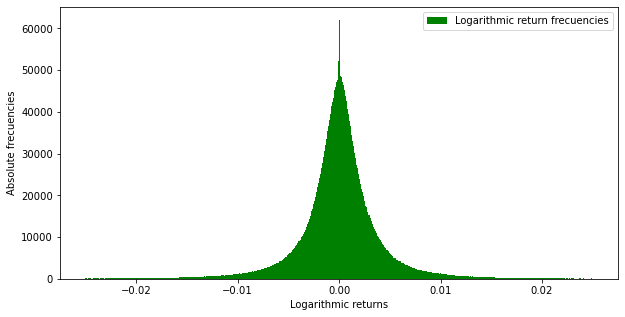

In [41]:
f = plt.figure(figsize=(10, 5))

plt.hist(y, bins=500, range=(-0.025, 0.025), label='Logarithmic return frecuencies', color='green')
plt.legend()
plt.xlabel('Logarithmic returns')
plt.ylabel('Absolute frecuencies')
plt.show()

In [63]:
# SCALING THE DATA
# The data scaling will be across time sequences. This means that for each feature in each sample 
# we will apply MinMaxScaler so that the only information that will be feeded to the neural network
# is if the feature behaviour. 

def scale_training_data(X):
    X_scaled = np.zeros((X.shape))
    for i in range(X.shape[-1]):
        scaler = MinMaxScaler()
        X_scaled[:, :, i] = scaler.fit_transform(X[:, :, i].T).T
    
    return X_scaled

X = scale_training_data(X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=27)

In [65]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))

x = Bidirectional(
        LSTM(
            units=64,
            input_shape=(X_train.shape[1], X_train.shape[2])
            )
    )(input_layer)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)

model = Model(input_layer, output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 31, 3)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               34816     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
67365/67365 [==============================] - 852s 13ms/step - loss: 2.3356e-05 - val_loss: 2.2592e-05
Epoch 2/10
67365/67365 [==============================] - 820s 12ms/step - loss: 2.3330e-05 - val_loss: 2.2547e-05
Epoch 3/10
67365/67365 [==============================] - 824s 12ms/step - loss: 2.3321e-05 - val_loss: 2.2542e-05
Epoch 4/10
67365/67365 [==============================] - 822s 12ms/step - loss: 2.3316e-05 - val_loss: 2.2534e-05
Epoch 5/10
67365/67365 [==============================] - 826s 12ms/step - loss: 2.3313e-05 - val_loss: 2.2535e-05
Epoch 6/10
67365/67365 [==============================] - 822s 12ms/step - loss: 2.3311e-05 - val_loss: 2.2535e-05
Epoch 7/10
67365/67365 [==============================] - 819s 12ms/step - loss: 2.3310e-05 - val_loss: 2.2535e-05
Epoch 8/10
67365/67365 [==============================] - 821s 12ms/step - loss: 2.3309e-05 - val_loss: 2.2533e-05
Epoch 9/10
67365/67365 [==============================] - 817s 12ms/step - loss:

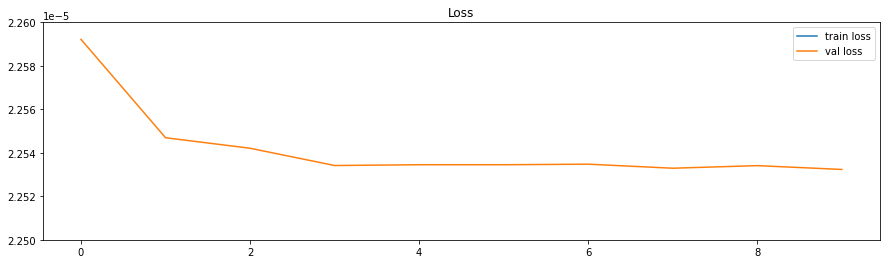

In [73]:
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.ylim(0.0000225, 0.0000234)
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))